In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import CONFIG, TORCH_GEN
from models.vl_encoders import MapComputeMode, VLEncoder, FLAIRAdapter
from data import image_UIDs, get_many_answer_gt, get_many_answer_pr, SegDataset, CLASS_MAP, flatten_class_splitted_answers, get_sc, get_gt, get_pr
from color_map import apply_colormap, COLOR_MAP_DICT, NUM_CLASSES
from viz import overlay_attn_map, display_token_length_distr, display_prompt
from utils import flatten_list
from path import SCS_PATH, GTS_PATH, get_mask_prs_path
from prompter import get_significant_classes

import torch
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
import seaborn as sns
from copy import deepcopy
from functools import partial
from pathlib import Path

from typing import Optional, Literal

In [3]:
# TODO use Git SubModules to integrate external repos in the project

# Attention Maps

In [4]:
def compute_maps_with_captions(
        model: VLEncoder,
        images: torch.Tensor,
        captions: list[str],
        mode: MapComputeMode,
        viz_image_size: Optional[int | list[int]] = None,
        map_resize_mode: TF.InterpolationMode = TF.InterpolationMode.NEAREST,
) -> list[tuple[Image.Image, str]]:
    image_text_list = []

    for img, text in zip(images, captions):
        img_tensor = model.preprocess_fn(to_pil_image(img)).to(CONFIG['device']).unsqueeze(0) # [1, 3, H_ite, W_ite]
        text_tensor = model.tokenizer([text]).to(CONFIG['device']).unsqueeze(0) # [1, context_length]
        logits = model.get_logits(img_tensor, text_tensor)
        attn_map, max_attn = model.get_maps(
            img_tensor, text_tensor,
            mode=mode,
            upsample_size=viz_image_size, upsample_mode=map_resize_mode,
            normalize=True) # [1, H, W], M
        attn_map = attn_map.squeeze(0) # [1, 1, H, W]
        if viz_image_size:
            img = TF.resize(img, size=viz_image_size, interpolation=TF.InterpolationMode.BILINEAR)
        ovr_img = overlay_attn_map(img, attn_map) # (H_viz, W_viz)

        image_text_list.append((ovr_img, f"LOGITS = {logits.item():.2f}", f"MAX ATTN = {max_attn.item():.2f}", text, "---"))

    return image_text_list

In [5]:
img_idxs = list(range(0, 8))
viz_image_size = 300
mode = MapComputeMode.ATTENTION

image_uids = image_UIDs[img_idxs]

In [6]:
model = FLAIRAdapter()

In [7]:
scs_paths = [SCS_PATH / (UID + ".jpg") for UID in image_uids]
scs = [get_sc(p, resize_size=CONFIG['seg']['image_size'], center_crop=True) for p in scs_paths] # tensors (3, H, W)
len(scs)

8

## Non-splitted

In [8]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
answers_gt_text = [answers_gt[i]['content'] for i in img_idxs]
len(answers_gt_text)

8

### Predictions Masks

In [9]:
alpha_pr = 0.5
map_resize_mode = TF.InterpolationMode.NEAREST

In [10]:
mask_prs_paths = [get_mask_prs_path("LRASPP_MobileNet_V3") / f"mask_pr_{i}.png" for i in img_idxs]
mask_prs = [apply_colormap(get_pr(p, class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True), COLOR_MAP_DICT, NUM_CLASSES) for p in mask_prs_paths] # tensors (3, H, W)
ovr_mask_prs = [to_tensor(Image.blend(to_pil_image(pr), to_pil_image(sc), alpha=alpha_pr)) for pr, sc in zip(mask_prs, scs)]
len(ovr_mask_prs)

8

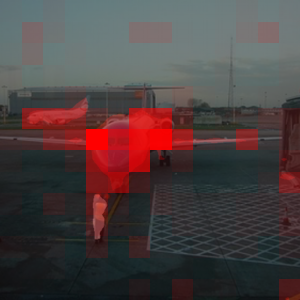

LOGITS = -1.39

MAX ATTN = 0.04

The ground truth AEROPLANE regions have been segmented in a coarser and incomplete way, especially regarding the wings, and two tiny AEROPLANE patches have been hallucinated on the right edge. The prediction mask for the ground truth PERSON region on the center-bottom-left is slightly more blob-like.


---

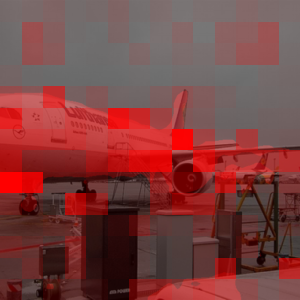

LOGITS = -3.45

MAX ATTN = 0.04

The ground truth AEROPLANE regions have been captured with irregular and erratic boundaries, while some AEROPLANE area has been hallucinated on the bottom of the scene.


---

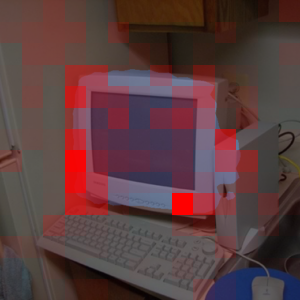

LOGITS = -10.49

MAX ATTN = 0.05

The ground truth MONITOR region on the center of the scene has been segmented with somewhat coarser and imperfect boundaries. The bottom and right boundaries of the region are especially flawed.


---

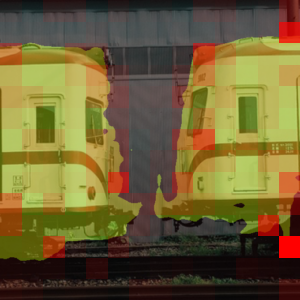

LOGITS = -0.69

MAX ATTN = 0.04

The prediction masks for the two ground truth TRAIN regions have some coarser boundaries, many details are lost.


---

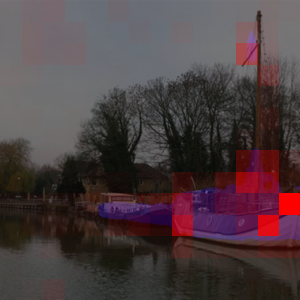

LOGITS = -6.45

MAX ATTN = 0.07

The prediction masks for the ground truth BOAT regions are coarser, imprecise and imperfect: the region on the right has been over-segmented a bit, while the region on the center has been slightly under-segmented and the vertical stripe on the right has mostly been missed.


---

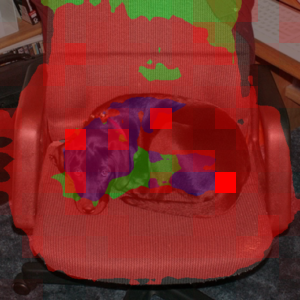

LOGITS = -4.94

MAX ATTN = 0.03

The prediction has many deviations from the ground truth and is overall much more chaotic. The prediction mask of the ground truth DOG region on the center is severily incomplete and irregular. The CHAIR region taking most of the scene has been segmented in a more irregular and erratic way, and the boundaries are inaccurate. Some area have been misclassified as SOFA instead of CHAIR on the top edge, and some has been misclassified as CHAIR instead of DOG in the center.


---

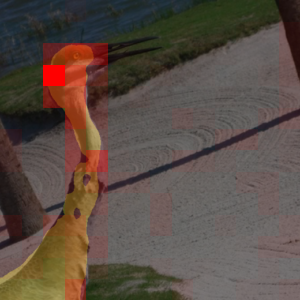

LOGITS = -5.12

MAX ATTN = 0.07

The prediction mask for the ground truth BIRD region misses the beak towards the top and has a couple of small holes in the center-bottom-left.


---

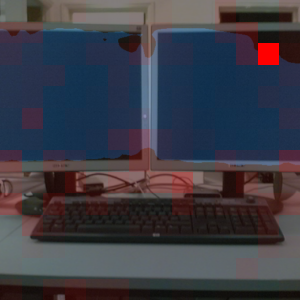

LOGITS = -10.01

MAX ATTN = 0.06

The prediction mask for the ground truth MONITOR regions are under-segmented towards the center-bottom (the monitor stands) and on the boundaries of the region towards the center-top and in the right corner. In general, the boundaries are a little less defined.


---

In [11]:
pr_image_text_list = compute_maps_with_captions(model, ovr_mask_prs, answers_gt_text, mode=mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode)
display_prompt(flatten_list(pr_image_text_list))

Contrastive analysis:

In [49]:
con_ovr_mask_prs = [ovr_mask_prs[0]]*int(len(ovr_mask_prs)/2) + [ovr_mask_prs[4]]*int(len(ovr_mask_prs)/2)
len(con_ovr_mask_prs)

8

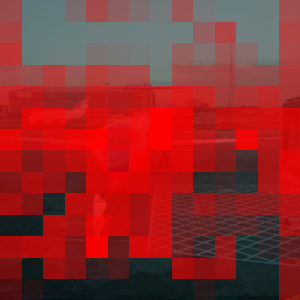

LOGITS = -1.39

MAX ATTN = 0.32

The ground truth AEROPLANE regions have been segmented in a coarser and incomplete way, especially regarding the wings, and two tiny AEROPLANE patches have been hallucinated on the right edge. The prediction mask for the ground truth PERSON region on the center-bottom-left is slightly more blob-like.


---

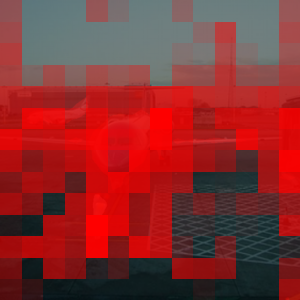

LOGITS = -3.47

MAX ATTN = 0.24

The ground truth AEROPLANE regions have been captured with irregular and erratic boundaries, while some AEROPLANE area has been hallucinated on the bottom of the scene.


---

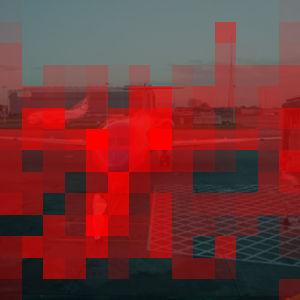

LOGITS = -8.94

MAX ATTN = 0.15

The ground truth MONITOR region on the center of the scene has been segmented with somewhat coarser and imperfect boundaries. The bottom and right boundaries of the region are especially flawed.


---

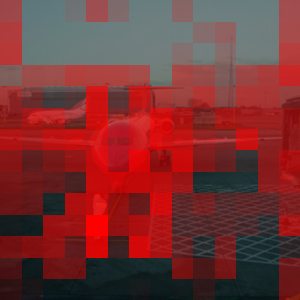

LOGITS = -4.67

MAX ATTN = 0.22

The prediction masks for the two ground truth TRAIN regions have some coarser boundaries, many details are lost.


---

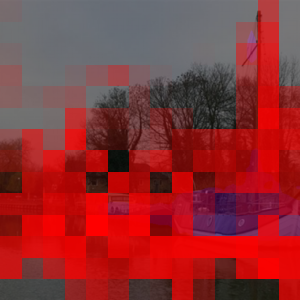

LOGITS = -6.45

MAX ATTN = 0.19

The prediction masks for the ground truth BOAT regions are coarser, imprecise and imperfect: the region on the right has been over-segmented a bit, while the region on the center has been slightly under-segmented and the vertical stripe on the right has mostly been missed.


---

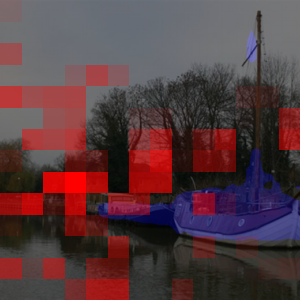

LOGITS = -18.72

MAX ATTN = 0.08

The prediction has many deviations from the ground truth and is overall much more chaotic. The prediction mask of the ground truth DOG region on the center is severily incomplete and irregular. The CHAIR region taking most of the scene has been segmented in a more irregular and erratic way, and the boundaries are inaccurate. Some area have been misclassified as SOFA instead of CHAIR on the top edge, and some has been misclassified as CHAIR instead of DOG in the center.


---

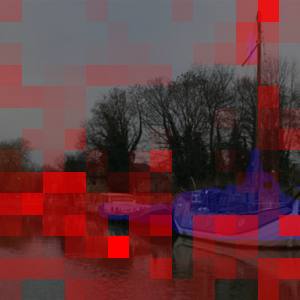

LOGITS = -13.75

MAX ATTN = 0.13

The prediction mask for the ground truth BIRD region misses the beak towards the top and has a couple of small holes in the center-bottom-left.


---

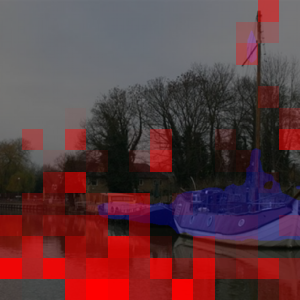

LOGITS = -15.59

MAX ATTN = 0.10

The prediction mask for the ground truth MONITOR regions are under-segmented towards the center-bottom (the monitor stands) and on the boundaries of the region towards the center-top and in the right corner. In general, the boundaries are a little less defined.


---

In [50]:
pr_image_text_list = compute_maps_with_captions(model, con_ovr_mask_prs, answers_gt_text, mode=mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode)
display_prompt(flatten_list(pr_image_text_list))

### Ground truth masks:

In [51]:
alpha_gt = 0.5
map_resize_mode = TF.InterpolationMode.NEAREST

In [52]:
mask_gts_paths = [GTS_PATH / (UID + ".png") for UID in image_uids]
mask_gts = [apply_colormap(get_gt(p, class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True), COLOR_MAP_DICT, NUM_CLASSES) for p in mask_gts_paths] # tensors (3, H, W)
ovr_mask_gts = [to_tensor(Image.blend(to_pil_image(gt), to_pil_image(sc), alpha=alpha_gt)) for gt, sc in zip(mask_gts, scs)]
len(ovr_mask_gts)

8

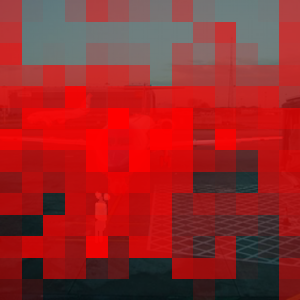

LOGITS = -1.86

MAX ATTN = 0.30

The ground truth AEROPLANE regions have been segmented in a coarser and incomplete way, especially regarding the wings, and two tiny AEROPLANE patches have been hallucinated on the right edge. The prediction mask for the ground truth PERSON region on the center-bottom-left is slightly more blob-like.


---

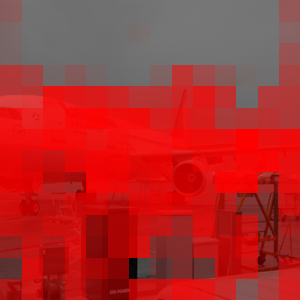

LOGITS = -3.42

MAX ATTN = 0.23

The ground truth AEROPLANE regions have been captured with irregular and erratic boundaries, while some AEROPLANE area has been hallucinated on the bottom of the scene.


---

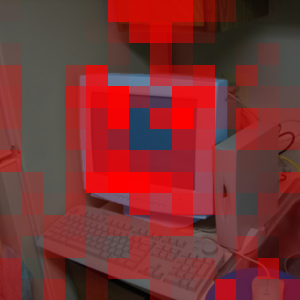

LOGITS = -10.67

MAX ATTN = 0.11

The ground truth MONITOR region on the center of the scene has been segmented with somewhat coarser and imperfect boundaries. The bottom and right boundaries of the region are especially flawed.


---

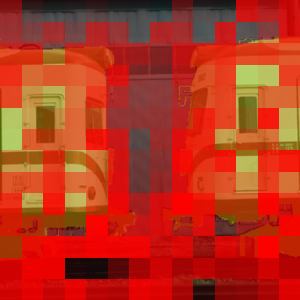

LOGITS = -2.03

MAX ATTN = 0.21

The prediction masks for the two ground truth TRAIN regions have some coarser boundaries, many details are lost.


---

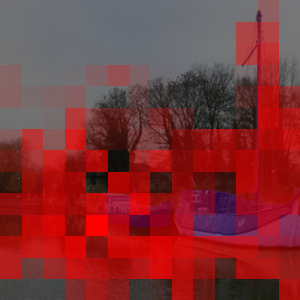

LOGITS = -7.69

MAX ATTN = 0.21

The prediction masks for the ground truth BOAT regions are coarser, imprecise and imperfect: the region on the right has been over-segmented a bit, while the region on the center has been slightly under-segmented and the vertical stripe on the right has mostly been missed.


---

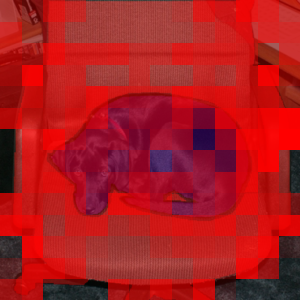

LOGITS = -2.12

MAX ATTN = 0.30

The prediction has many deviations from the ground truth and is overall much more chaotic. The prediction mask of the ground truth DOG region on the center is severily incomplete and irregular. The CHAIR region taking most of the scene has been segmented in a more irregular and erratic way, and the boundaries are inaccurate. Some area have been misclassified as SOFA instead of CHAIR on the top edge, and some has been misclassified as CHAIR instead of DOG in the center.


---

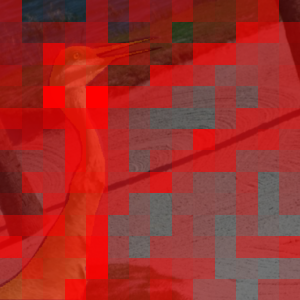

LOGITS = -2.36

MAX ATTN = 0.23

The prediction mask for the ground truth BIRD region misses the beak towards the top and has a couple of small holes in the center-bottom-left.


---

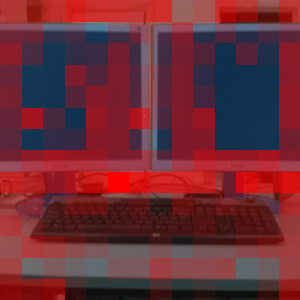

LOGITS = -9.41

MAX ATTN = 0.18

The prediction mask for the ground truth MONITOR regions are under-segmented towards the center-bottom (the monitor stands) and on the boundaries of the region towards the center-top and in the right corner. In general, the boundaries are a little less defined.


---

In [53]:
gt_image_text_list = compute_maps_with_captions(model, ovr_mask_gts, answers_gt_text, mode=mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode)
display_prompt(flatten_list(gt_image_text_list))

Contrastive analysis:

In [54]:
con_ovr_mask_gts = [ovr_mask_gts[0]]*int(len(ovr_mask_gts)/2) + [ovr_mask_gts[4]]*int(len(ovr_mask_gts)/2)
len(con_ovr_mask_gts)

8

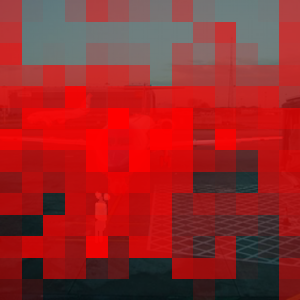

LOGITS = -1.86

MAX ATTN = 0.30

The ground truth AEROPLANE regions have been segmented in a coarser and incomplete way, especially regarding the wings, and two tiny AEROPLANE patches have been hallucinated on the right edge. The prediction mask for the ground truth PERSON region on the center-bottom-left is slightly more blob-like.


---

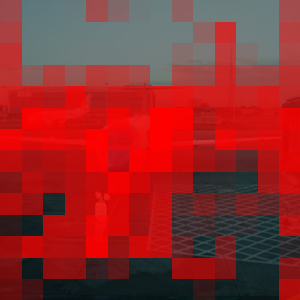

LOGITS = -3.66

MAX ATTN = 0.23

The ground truth AEROPLANE regions have been captured with irregular and erratic boundaries, while some AEROPLANE area has been hallucinated on the bottom of the scene.


---

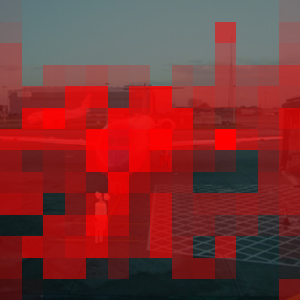

LOGITS = -8.49

MAX ATTN = 0.15

The ground truth MONITOR region on the center of the scene has been segmented with somewhat coarser and imperfect boundaries. The bottom and right boundaries of the region are especially flawed.


---

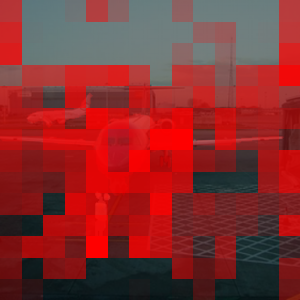

LOGITS = -5.69

MAX ATTN = 0.16

The prediction masks for the two ground truth TRAIN regions have some coarser boundaries, many details are lost.


---

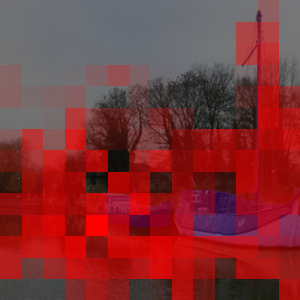

LOGITS = -7.69

MAX ATTN = 0.21

The prediction masks for the ground truth BOAT regions are coarser, imprecise and imperfect: the region on the right has been over-segmented a bit, while the region on the center has been slightly under-segmented and the vertical stripe on the right has mostly been missed.


---

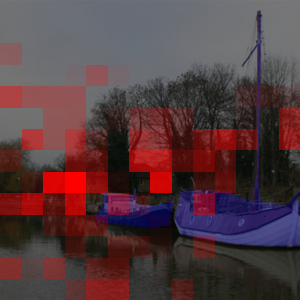

LOGITS = -19.07

MAX ATTN = 0.10

The prediction has many deviations from the ground truth and is overall much more chaotic. The prediction mask of the ground truth DOG region on the center is severily incomplete and irregular. The CHAIR region taking most of the scene has been segmented in a more irregular and erratic way, and the boundaries are inaccurate. Some area have been misclassified as SOFA instead of CHAIR on the top edge, and some has been misclassified as CHAIR instead of DOG in the center.


---

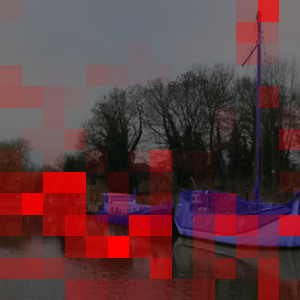

LOGITS = -14.43

MAX ATTN = 0.11

The prediction mask for the ground truth BIRD region misses the beak towards the top and has a couple of small holes in the center-bottom-left.


---

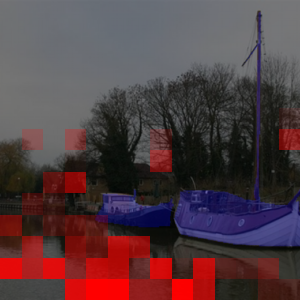

LOGITS = -17.56

MAX ATTN = 0.09

The prediction mask for the ground truth MONITOR regions are under-segmented towards the center-bottom (the monitor stands) and on the boundaries of the region towards the center-top and in the right corner. In general, the boundaries are a little less defined.


---

In [55]:
gt_image_text_list = compute_maps_with_captions(model, con_ovr_mask_gts, answers_gt_text, mode=mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode)
display_prompt(flatten_list(gt_image_text_list))

## Class-splitted

In [56]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
cs_answers_pr = get_many_answer_pr(prs_path, return_state=False)
cs_answers_pr_text = [list(cs_answers_pr[i]['content'].values()) for i in img_idxs]
len(cs_answers_pr_text)

8

### Prediction Masks

In [57]:
alpha_pr = 0.5
map_resize_mode = TF.InterpolationMode.NEAREST

In [58]:
significant_classes_pr = [get_significant_classes(get_mask_prs_path("LRASPP_MobileNet_V3") / (f"mask_pr_{i}.png"), CONFIG['seg']['image_size'], CLASS_MAP)  for i in img_idxs]
significant_classes_pr[3] = [19] # for some reason, class '15' appears as well but there is no answer for it.

In [59]:
cs_color_map_dicts = [list({c: [255, 255, 255] if c == pos_class else [0, 0, 0] for c in range(NUM_CLASSES)} for pos_class in classes) for classes in significant_classes_pr]
cs_mask_prs = [list(apply_colormap(get_pr(mask_prs_paths[i], class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True), cs_color_map_dicts[i][t], NUM_CLASSES) for t, pos_class in enumerate(classes)) for i, classes in enumerate(significant_classes_pr)]
cs_ovr_mask_prs = [list(to_tensor(Image.blend(to_pil_image(pr), to_pil_image(sc), alpha=alpha_pr)) for pr in cs_prs) for cs_prs, sc in zip(cs_mask_prs, scs)]
len(cs_ovr_mask_prs)

8

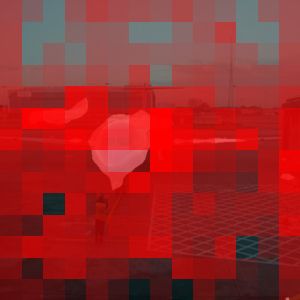

LOGITS = -4.73

MAX ATTN = 0.32

The prediction mask of the AEROPLANE region is significantly incomplete. A large portion of the fuselage is missing, and the tail section is also not fully captured. The boundaries are quite irregular and noisy, indicating a poor segmentation of the AEROPLANE class.

---

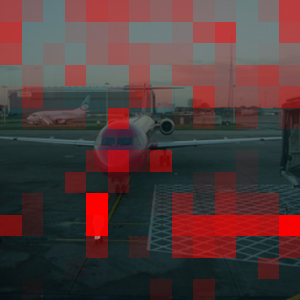

LOGITS = -15.51

MAX ATTN = 0.12

The prediction mask of the PERSON region is significantly incomplete. It only captures a small portion of the ground truth PERSON, missing the head and upper body. The boundaries are also quite rough and do not accurately reflect the shape of the PERSON.

---

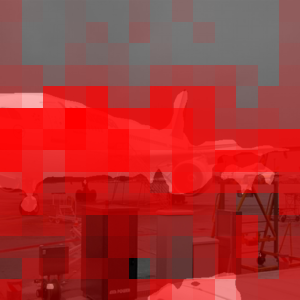

LOGITS = -4.41

MAX ATTN = 0.34

The prediction mask of the AEROPLANE class deviates significantly from the ground truth. The prediction is incomplete, missing large portions of the fuselage and tail. Furthermore, the prediction has hallucinated some regions outside the actual AEROPLANE, particularly around the landing gear area. The boundaries of the AEROPLANE are also quite irregular and imprecise.

---

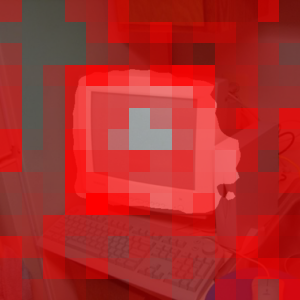

LOGITS = -6.68

MAX ATTN = 0.23

The prediction mask of the TVMONITOR region is quite noisy, with several small disconnected areas appearing outside the ground truth boundary. The boundary of the TVMONITOR is also less precise in the prediction, showing a jagged edge compared to the smoother boundary in the ground truth.

---

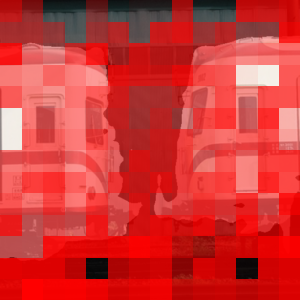

LOGITS = -3.92

MAX ATTN = 0.33

The prediction mask of the TRAIN class is mostly accurate, but there are some noticeable deviations. The lower part of the TRAIN region on the right side of the scene is missing in the prediction, while the ground truth shows a complete segmentation. The boundary of the TRAIN region on the left side is also less defined in the prediction.

---

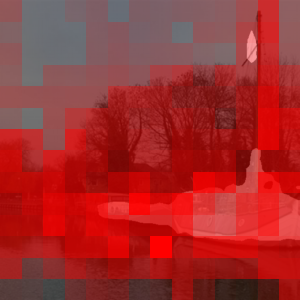

LOGITS = -4.84

MAX ATTN = 0.25

The prediction mask of the BOAT region is quite rough and lacks fine details compared to the ground truth. Specifically, the boundary of the BOAT is not accurately captured, resulting in a jagged and less defined edge.

---

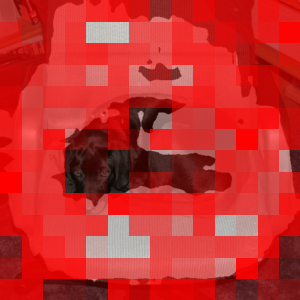

LOGITS = -3.15

MAX ATTN = 0.33

The prediction mask accurately identifies the CHAIR region, but the segmentation is quite coarse. The boundaries of the CHAIR are not well-defined, resulting in a jagged and less precise outline compared to the ground truth.

---

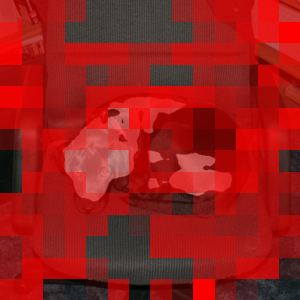

LOGITS = -7.15

MAX ATTN = 0.22

The prediction mask of the DOG region is quite fragmented and incomplete compared to the ground truth. Large portions of the DOG are missed, particularly around the edges and the head. The prediction also introduces some false positives, segmenting areas outside the actual DOG shape.

---

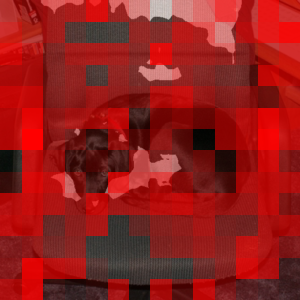

LOGITS = -7.48

MAX ATTN = 0.23

The prediction mask of the SOFA region is quite fragmented and incomplete. It fails to capture the entire SOFA area, leaving large portions unsegmented. The boundaries are also quite irregular and do not follow the shape of the ground truth SOFA.

---

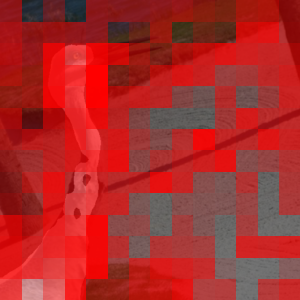

LOGITS = 1.28

MAX ATTN = 0.35

The prediction mask of the BIRD region is quite rough, with several holes appearing in the neck and head areas. The boundary of the BIRD is also not well-defined, showing significant deviations from the ground truth.

---

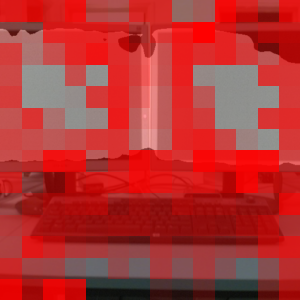

LOGITS = -7.54

MAX ATTN = 0.19

The prediction mask for the TVMONITOR class closely follows the ground truth. However, the boundaries of the TVMONITOR regions are slightly less precise in the prediction, particularly around the edges of the screens and the stands.

---

In [60]:
cs_pr_image_text_list = [compute_maps_with_captions(model, ovr_mask_prs, answers_pr_text, mode=mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode) for ovr_mask_prs, answers_pr_text in zip(cs_ovr_mask_prs, cs_answers_pr_text)]
display_prompt(flatten_list(cs_pr_image_text_list))

# Token Length Analysis

In [24]:
model = FLAIRAdapter()

**Ground truths** (non-splitted):

In [25]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
captions = [a['content'] for a in answers_gt]
tok_lengths = [model.count_tokens(t) for t in captions]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

80

critical_answers_amount=4


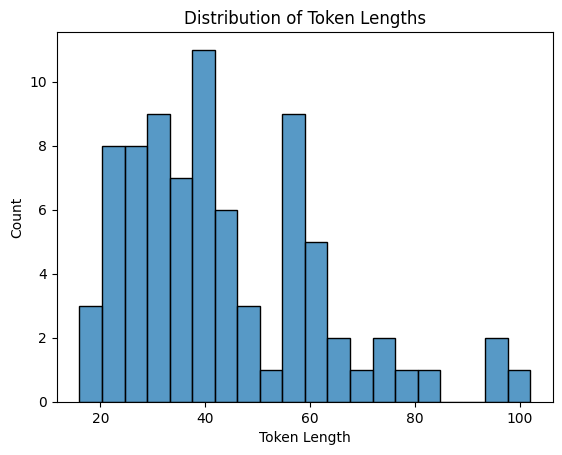

In [26]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Class-splitted predictions**:

In [27]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
answers_pr = flatten_class_splitted_answers(get_many_answer_pr(prs_path, return_state=False))
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

144

critical_answers_amount=2


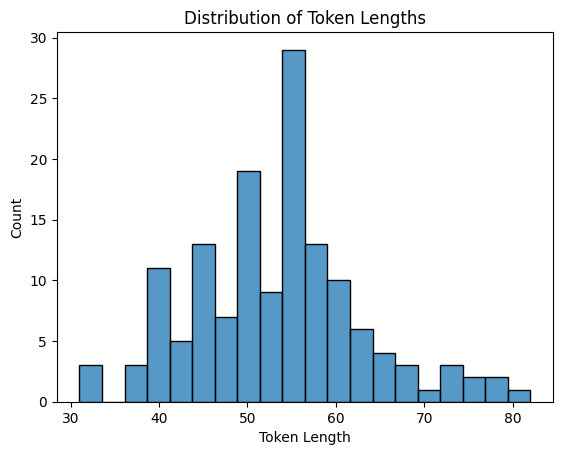

In [28]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Non-splitted predictions**:

In [29]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/non-splitted/answer_prs/gemini-2.0-flash/baseline/SepMasks_Ovr.jsonl")
answers_pr = get_many_answer_pr(prs_path, return_state=False)
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

77

critical_answers_amount=3


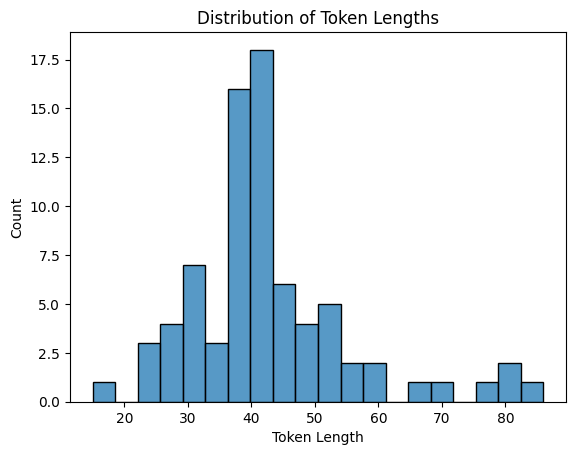

In [30]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

# Demo

In [31]:
model = FLAIRAdapter()

(453, 604)


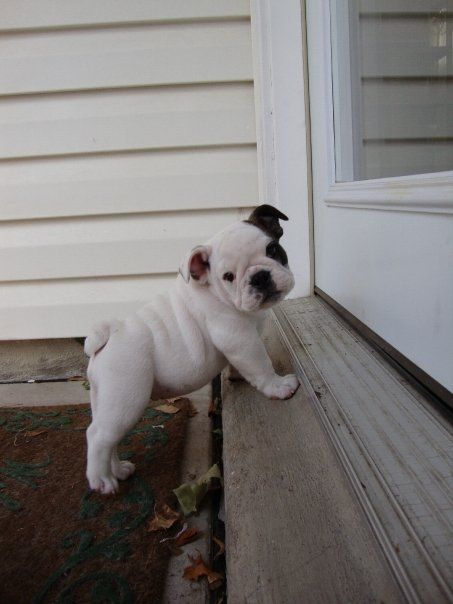

In [32]:
image = Image.open("/home/olivieri/exp/resources/puppy.jpg")
print(image.size)
image

In [33]:
image_tensor = model.preprocess_fn(image).to(CONFIG['device'])
images_tensor = torch.stack([image_tensor]*4, dim=0)
images_tensor.shape

torch.Size([4, 3, 224, 224])

In [34]:
texts_tensor = model.tokenizer([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
    "Dominating the scene is a white desk, positioned against a white brick wall" # non-ground-truth caption
]).to(CONFIG['device'])

In [35]:
# with torch.no_grad(), torch.cuda.amp.autocast():
with torch.no_grad(), torch.amp.autocast(CONFIG['device']):
    flair_logits = model.get_logits(images=images_tensor, texts=texts_tensor, broadcast=False)

flair_logits # [4.4062,  6.9531, -20.5000, -18.1719]

tensor([[  4.3906],
        [  6.9531],
        [-20.5000],
        [-18.1719]], device='cuda:0', dtype=torch.float16)

In [36]:
attn_maps, max_attn = model.get_attn_maps(images_tensor, texts_tensor, upsample_size=image.size[::-1], normalize=True, broadcast=False)
attn_maps.shape

torch.Size([4, 1, 604, 453])

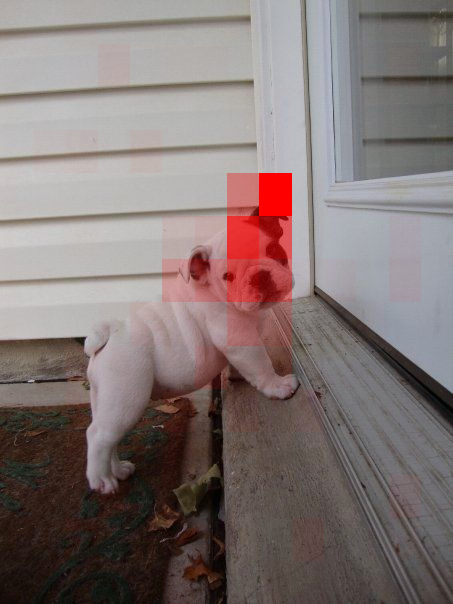

In [37]:
overlay_attn_map(image, attn_maps[0])